# Wrangling lifelog data (July 2019–January 2020)
Natalia Vélez, December 2019–January 2020

In this notebook:

* Load, clean up lifelog data from 2019-07-30 to 2020-01-08
* Split data by version
* Prepare inputs for subsequent analyses (census, family trees, migration patterns)

The period studied spans the start of the MapChange logs to the most recent data download (versions 251–302)

In [1]:
%matplotlib inline

import os, re, glob, random
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as opj
from tqdm import tqdm_notebook
from ast import literal_eval as make_tuple

sns.set_context('paper')

Helper functions:

In [2]:
gsearch = lambda *args: glob.glob(opj(*args))
str_extract = lambda pattern, s: re.search(pattern, s).group(0)

## Parse version history

In future analyses, we'll want to split data by release; different releases of the game will have different items, mechanics, etc. To do that, we'll parse the version history here and get the start and end dates for each release.

In [3]:
ver_file = '../1_download/outputs/version_history_full.tsv'

# Load file
ver = pd.read_csv(ver_file, sep='\t')

# Clean up release date
ver.release_date = [s.replace('-', '') for s in ver.release_date]
ver.release_date = pd.to_numeric(ver.release_date)

ver.head()

,version,release_date
0,302,20200109
1,300,20200103
2,298,20191220
3,297,20191218
4,296,20191214


`find_version`: Helper function. Takes a filename as input, finds the corresponding release.

In [12]:
def find_version(file):
    file_date = date_extract(file)

    tmp_ver = ver.copy()
    tmp_ver['lag'] = file_date - tmp_ver['release_date']
    tmp_ver = tmp_ver[tmp_ver['lag'] >= 0]

    file_ver = tmp_ver.loc[tmp_ver['lag'].idxmax()].version
    
    return file_ver

## Clean up data

We first need to filter files by date, to pick out files within the range we're interested in. (This might be a roundabout way of doing it—suggestions welcome.)

`date_extract`: Helper function. Takes a basename as a string (e.g., '2019_03March_23_Saturday.txt') and returns an integer representation of the date (e.g., 20190323).

In [5]:
def date_extract(s):
    
    date_regex = '([0-9]{4})_([0-9]{2})[A-Za-z]+_([0-9]{2})'
    date_search = re.findall(date_regex, s)
    date_str = ''.join(date_search[0])
    date_int = int(date_str)
    
    return date_int

List all files:

In [6]:
data_dir = '../data'
all_files = gsearch(data_dir, 'publicLifeLogData', 'lifeLog*', '2*y.txt')
all_files.sort()
print(*all_files[:10], sep='\n')

../data/publicLifeLogData/lifeLog_bigserver1.onehouronelife.com/2019_01January_25_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver1.onehouronelife.com/2019_01January_26_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver1.onehouronelife.com/2019_01January_27_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver1.onehouronelife.com/2019_01January_28_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver1.onehouronelife.com/2019_01January_29_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver1.onehouronelife.com/2019_01January_30_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_01January_29_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_01January_30_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_01January_31_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_02February_01_Friday.txt


Extract dates:

In [7]:
all_dates = [date_extract(f) for f in all_files]
print(*all_dates[:10], sep='\n')

20190125
20190126
20190127
20190128
20190129
20190130
20190129
20190130
20190131
20190201


Filter files within range:

In [8]:
start = 20190730
end = 20200108

# Check if date is within range
between_dates = lambda d: (d >= start) & (d <= end)

file_df = pd.DataFrame({'file': all_files,
                        'date': all_dates})
file_df['include'] = file_df.date.apply(between_dates)
file_df = file_df[file_df.include == True]

file_df.head()

,file,date,include
188,../data/publicLifeLogData/lifeLog_bigserver2.o...,20190730,True
189,../data/publicLifeLogData/lifeLog_bigserver2.o...,20190731,True
190,../data/publicLifeLogData/lifeLog_bigserver2.o...,20190801,True
191,../data/publicLifeLogData/lifeLog_bigserver2.o...,20190802,True
192,../data/publicLifeLogData/lifeLog_bigserver2.o...,20190803,True


In [9]:
data_files = file_df['file'].values
print('%i files found' % len(data_files))
print(*[os.path.basename(f) for f in data_files[:20]], sep='\n')

2341 files found
2019_07July_30_Tuesday.txt
2019_07July_31_Wednesday.txt
2019_08August_01_Thursday.txt
2019_08August_02_Friday.txt
2019_08August_03_Saturday.txt
2019_08August_04_Sunday.txt
2019_08August_05_Monday.txt
2019_08August_06_Tuesday.txt
2019_08August_07_Wednesday.txt
2019_08August_08_Thursday.txt
2019_08August_09_Friday.txt
2019_08August_10_Saturday.txt
2019_08August_11_Sunday.txt
2019_08August_12_Monday.txt
2019_08August_13_Tuesday.txt
2019_08August_14_Wednesday.txt
2019_08August_15_Thursday.txt
2019_08August_16_Friday.txt
2019_08August_17_Saturday.txt
2019_08August_18_Sunday.txt


Load all files:

In [14]:
data_list = []
empty_files = []
for f in tqdm_notebook(data_files):
    try:
        tmp_server = str_extract('(?<=lifeLog_)[a-zA-Z0-9]+', f)
        tmp_ver = find_version(f)
        
        tmp_d = pd.read_csv(f, sep =' ', header=None)
        tmp_d.insert(0, 'server', tmp_server)
        tmp_d.insert(0, 'release', tmp_ver)
        data_list.append(tmp_d)
    except:
        empty_files.append(f)

In [15]:
raw_data = pd.concat(data_list)
raw_data.head()

,release,server,0,1,2,3,4,5,6,7,8
0,27,bigserver2,D,1564444828,1842380,583a6de73718f5dd0ddf388f4e68dc060b15e6df,age=1.81,F,"(48,94)",hunger,pop=82
1,27,bigserver2,D,1564444830,1842301,520ddb069aa77dcb202dd0310a8852e8fddc58dd,age=8.00,M,"(40,350)",hunger,pop=82
2,27,bigserver2,B,1564444832,1842398,583a6de73718f5dd0ddf388f4e68dc060b15e6df,F,"(-325,209)",parent=1842145,pop=84,chain=3
3,27,bigserver2,B,1564444836,1842399,520ddb069aa77dcb202dd0310a8852e8fddc58dd,M,"(67,-266)",parent=1842397,pop=83,chain=2
4,27,bigserver2,D,1564444859,1842311,dfd85ac03c4dd577352484b023d19d521b592696,age=7.76,M,"(-200,-123)",hunger,pop=82


Deaths:

In [18]:
death_raw = raw_data[raw_data.iloc[:,2] == 'D'].copy().reset_index(drop=True)
death_raw.head()

,release,server,0,1,2,3,4,5,6,7,8
0,27,bigserver2,D,1564444828,1842380,583a6de73718f5dd0ddf388f4e68dc060b15e6df,age=1.81,F,"(48,94)",hunger,pop=82
1,27,bigserver2,D,1564444830,1842301,520ddb069aa77dcb202dd0310a8852e8fddc58dd,age=8.00,M,"(40,350)",hunger,pop=82
2,27,bigserver2,D,1564444859,1842311,dfd85ac03c4dd577352484b023d19d521b592696,age=7.76,M,"(-200,-123)",hunger,pop=82
3,27,bigserver2,D,1564444861,1842145,f766576701306189b31a049054c0840b39f84c51,age=18.89,F,"(-322,242)",hunger,pop=82
4,27,bigserver2,D,1564444863,1842359,9381dc0dab74b62eee67d3dc275f5c61ea51bcd0,age=4.23,M,"(-308,258)",hunger,pop=82


Births:

In [19]:
birth_raw = raw_data[raw_data.iloc[:,2] == 'B'].copy().reset_index(drop=True)
birth_raw.head()

,release,server,0,1,2,3,4,5,6,7,8
0,27,bigserver2,B,1564444832,1842398,583a6de73718f5dd0ddf388f4e68dc060b15e6df,F,"(-325,209)",parent=1842145,pop=84,chain=3
1,27,bigserver2,B,1564444836,1842399,520ddb069aa77dcb202dd0310a8852e8fddc58dd,M,"(67,-266)",parent=1842397,pop=83,chain=2
2,27,bigserver2,B,1564444863,1842400,dfd85ac03c4dd577352484b023d19d521b592696,M,"(16,-57)",parent=1842304,pop=84,chain=2
3,27,bigserver2,B,1564444864,1842401,fd6e14532b361175d5203c50a22d20fe951c89f0,M,"(146,49)",parent=1842336,pop=84,chain=2
4,27,bigserver2,B,1564444866,1842402,f766576701306189b31a049054c0840b39f84c51,F,"(68,64)",parent=1842334,pop=84,chain=2


### Clean up data

In [21]:
shared_header = ['release', 'server', 'event', 'timestamp', 'playerID', 'hash', 'uniqueID', 'age', 'sex',
                 'location', 'parent', 'cause_of_death', 'killer', 'pop', 'chain']

#### Deaths

In [27]:
death_data = death_raw.copy()
# Insert missing columns
death_data.insert(6, 'uniqueID', np.nan)
death_data.insert(10, 'parent', np.nan)
death_data.insert(13, 'chain', np.nan)
death_data.insert(12, 'killer', np.nan)
death_data.columns = shared_header

for i, row in tqdm_notebook(death_data.iterrows(), total=death_data.shape[0]):
    age = str_extract('(?<=age=)\d+\.\d+', row['age'])
    age = float(age)
    
    pop = str_extract('(?<=pop=)[0-9]+', row['pop'])
    pop = int(pop)
    
    death_data.at[i, 'age'] = age
    death_data.at[i, 'pop'] = pop

Clean up IDs,  locations, causes of death

In [28]:
# Unique ID: Player ID + hash
death_data['uniqueID'] = death_data.apply(lambda row: '%s_%s_%s' % (row['playerID'], row['server'], row['release']),
                                          axis=1)

# Locations
death_data['location'] = death_data['location'].apply(make_tuple)

# Check for murdered players
murderers = death_data['cause_of_death'].str.extract(r'(?<=killer_)([0-9]+)', expand=False)
death_data['cause_of_death'] = death_data['cause_of_death'].str.replace("killer_[0-9]+", "murdered")
death_data['killer'] = murderers

print(death_data['cause_of_death'].unique())
print(death_data['killer'].unique()[:10])

death_data.head()

['hunger' 'disconnect' 'murdered' 'oldAge']
[nan '1841694' '1841943' '1841921' '1842167' '1841831' '1842476' '1842228'
 '1842430' '1842343']


,release,server,event,timestamp,playerID,hash,uniqueID,age,sex,location,parent,cause_of_death,killer,pop,chain
0,27,bigserver2,D,1564444828,1842380,583a6de73718f5dd0ddf388f4e68dc060b15e6df,1842380_bigserver2_27,1.81,F,"(48, 94)",NaN,hunger,NaN,82,NaN
1,27,bigserver2,D,1564444830,1842301,520ddb069aa77dcb202dd0310a8852e8fddc58dd,1842301_bigserver2_27,8,M,"(40, 350)",NaN,hunger,NaN,82,NaN
2,27,bigserver2,D,1564444859,1842311,dfd85ac03c4dd577352484b023d19d521b592696,1842311_bigserver2_27,7.76,M,"(-200, -123)",NaN,hunger,NaN,82,NaN
3,27,bigserver2,D,1564444861,1842145,f766576701306189b31a049054c0840b39f84c51,1842145_bigserver2_27,18.89,F,"(-322, 242)",NaN,hunger,NaN,82,NaN
4,27,bigserver2,D,1564444863,1842359,9381dc0dab74b62eee67d3dc275f5c61ea51bcd0,1842359_bigserver2_27,4.23,M,"(-308, 258)",NaN,hunger,NaN,82,NaN


#### Births

In [29]:
birth_data = birth_raw.copy()
# Insert missing columns
birth_data.insert(6, 'uniqueID', np.nan)
birth_data.insert(7, 'age', np.nan)
birth_data.insert(11, 'cause_of_death', np.nan)
birth_data.insert(12, 'killer', np.nan)
birth_data.columns = shared_header

for i, row in tqdm_notebook(birth_data.iterrows(), total=birth_data.shape[0]):    
    pop = str_extract('(?<=pop=)[0-9]+', row['pop'])
    pop = int(pop)
    
    chain = str_extract('(?<=chain=)[0-9]+', row['chain'])
    chain = int(chain)
    
    birth_data.at[i, 'pop'] = pop
    birth_data.at[i, 'chain'] = chain

birth_data.head()

,release,server,event,timestamp,playerID,hash,uniqueID,age,sex,location,parent,cause_of_death,killer,pop,chain
0,27,bigserver2,B,1564444832,1842398,583a6de73718f5dd0ddf388f4e68dc060b15e6df,NaN,NaN,F,"(-325,209)",parent=1842145,NaN,NaN,84,3
1,27,bigserver2,B,1564444836,1842399,520ddb069aa77dcb202dd0310a8852e8fddc58dd,NaN,NaN,M,"(67,-266)",parent=1842397,NaN,NaN,83,2
2,27,bigserver2,B,1564444863,1842400,dfd85ac03c4dd577352484b023d19d521b592696,NaN,NaN,M,"(16,-57)",parent=1842304,NaN,NaN,84,2
3,27,bigserver2,B,1564444864,1842401,fd6e14532b361175d5203c50a22d20fe951c89f0,NaN,NaN,M,"(146,49)",parent=1842336,NaN,NaN,84,2
4,27,bigserver2,B,1564444866,1842402,f766576701306189b31a049054c0840b39f84c51,NaN,NaN,F,"(68,64)",parent=1842334,NaN,NaN,84,2


Clean up IDs, locations, parents:

In [30]:
birth_data['uniqueID'] = birth_data.apply(lambda row: '%s_%s_%s' % (row['playerID'], row['server'], row['release']), 
                                          axis=1)
birth_data['location'] = birth_data['location'].apply(make_tuple)
birth_data['parent'] = birth_data['parent'].str.extract(r'(?<=parent=)([0-9]+)')

birth_data.head()

,release,server,event,timestamp,playerID,hash,uniqueID,age,sex,location,parent,cause_of_death,killer,pop,chain
0,27,bigserver2,B,1564444832,1842398,583a6de73718f5dd0ddf388f4e68dc060b15e6df,1842398_bigserver2_27,NaN,F,"(-325, 209)",1842145,NaN,NaN,84,3
1,27,bigserver2,B,1564444836,1842399,520ddb069aa77dcb202dd0310a8852e8fddc58dd,1842399_bigserver2_27,NaN,M,"(67, -266)",1842397,NaN,NaN,83,2
2,27,bigserver2,B,1564444863,1842400,dfd85ac03c4dd577352484b023d19d521b592696,1842400_bigserver2_27,NaN,M,"(16, -57)",1842304,NaN,NaN,84,2
3,27,bigserver2,B,1564444864,1842401,fd6e14532b361175d5203c50a22d20fe951c89f0,1842401_bigserver2_27,NaN,M,"(146, 49)",1842336,NaN,NaN,84,2
4,27,bigserver2,B,1564444866,1842402,f766576701306189b31a049054c0840b39f84c51,1842402_bigserver2_27,NaN,F,"(68, 64)",1842334,NaN,NaN,84,2


#### Save outputs

In [31]:
lifelog_data = pd.concat([death_data, birth_data])
lifelog_data = lifelog_data.sort_values(by=['server', 'timestamp'])
lifelog_data = lifelog_data.reset_index(drop=True)

lifelog_data.head()

,release,server,event,timestamp,playerID,hash,uniqueID,age,sex,location,parent,cause_of_death,killer,pop,chain
0,27,bigserver2,D,1564444828,1842380,583a6de73718f5dd0ddf388f4e68dc060b15e6df,1842380_bigserver2_27,1.81,F,"(48, 94)",NaN,hunger,NaN,82,NaN
1,27,bigserver2,D,1564444830,1842301,520ddb069aa77dcb202dd0310a8852e8fddc58dd,1842301_bigserver2_27,8,M,"(40, 350)",NaN,hunger,NaN,82,NaN
2,27,bigserver2,B,1564444832,1842398,583a6de73718f5dd0ddf388f4e68dc060b15e6df,1842398_bigserver2_27,NaN,F,"(-325, 209)",1842145,NaN,NaN,84,3
3,27,bigserver2,B,1564444836,1842399,520ddb069aa77dcb202dd0310a8852e8fddc58dd,1842399_bigserver2_27,NaN,M,"(67, -266)",1842397,NaN,NaN,83,2
4,27,bigserver2,D,1564444859,1842311,dfd85ac03c4dd577352484b023d19d521b592696,1842311_bigserver2_27,7.76,M,"(-200, -123)",NaN,hunger,NaN,82,NaN


In [32]:
out_file = 'outputs/lifelogs_201907_data.csv'
lifelog_data.to_csv(out_file, sep='\t', index=False)

## Census: How many players?

In [33]:
lifelog_data.groupby('event').agg({'event': 'count'})

,event
event,
B,704781
D,703717


## Deaths: How and when do people die?

Age of death:

Plotting 703717 deaths


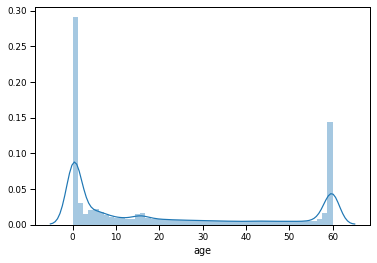

In [34]:
print('Plotting %i deaths' % len(death_data))
sns.distplot(death_data['age'])

Frequency of causes of death:

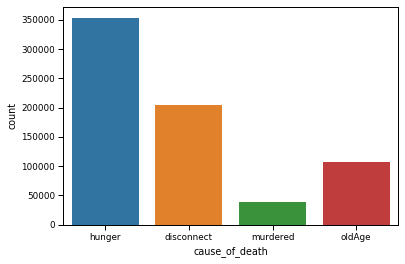

In [35]:
sns.countplot(x='cause_of_death', data=death_data)

Age by cause of death:

/anaconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


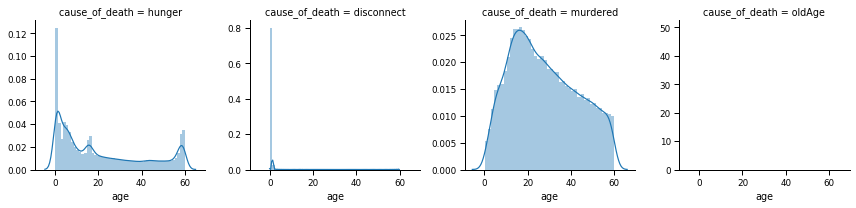

In [36]:
g = sns.FacetGrid(death_data, col='cause_of_death', sharey=False)
g.map(sns.distplot, "age")

## Births: Charting family trees

### Prepare data

In [ ]:
graph_data = birth_data[['playerID', 'parent']].copy()
graph_data = graph_data.rename(columns={"playerID": "child"})
graph_data['child'] = graph_data['child'].astype(np.float)
graph_data['parent'] = np.where(graph_data['parent'] == 'noParent', 
                                np.nan,
                                graph_data['parent'].str.replace('parent=', ''))
graph_data['parent'] = graph_data['parent'].astype(np.float)
graph_data.head()

#### Data quality checks

How many nodes?

In [ ]:
graph_data.nunique()

Are the entries in "children" a subset of "parent"?

In [ ]:
children = graph_data['child'].unique()
parents = graph_data['parent'].unique()
parents = parents[~np.isnan(parents)]

In [ ]:
np.all([p in children for p in parents])

Draw graph:

In [ ]:
family_graph = nx.from_pandas_edgelist(graph_data, source='parent', target='child')

In [ ]:
nx.draw_random(family_graph, with_labels=False)